In [11]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [12]:
ppp = pd.read_csv('../data/cleaned_1and2_reduced.csv')
ppp.head()

,SBAOfficeCode,ProcessingMethod,LoanStatus,Term,SBAGuarantyPercentage,InitialApprovalAmount,CurrentApprovalAmount,ServicingLenderLocationID,RuralUrbanIndicator,HubzoneIndicator,...,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,REFINANCE_EIDL_PROCEED,HEALTH_CARE_PROCEED,DEBT_INTEREST_PROCEED,BusinessType,OriginatingLenderLocationID,Gender,Veteran
0,156,PPP,1,24,100,18457.00,18457.00,9551,U,N,...,18457.00,0.0,0.0,0.0,0.0,0.0,Limited Liability Company(LLC),9551,Unanswered,Unanswered
1,156,PPP,1,24,100,18457.00,18457.00,9551,U,N,...,18457.00,0.0,0.0,0.0,0.0,0.0,Corporation,9551,Female Owned,Unanswered
2,156,PPS,1,60,100,18456.65,18456.65,93682,R,N,...,18450.65,0.0,0.0,0.0,0.0,0.0,Limited Liability Company(LLC),93682,Female Owned,Non-Veteran
3,156,PPP,1,60,100,18456.00,18456.00,93490,U,N,...,18455.00,0.0,0.0,0.0,0.0,0.0,Single Member LLC,93490,Male Owned,Non-Veteran
4,156,PPP,1,60,100,18455.00,18455.00,433860,U,N,...,18455.00,0.0,0.0,0.0,0.0,0.0,Corporation,529111,Unanswered,Unanswered


What is our full parameter set?

In [13]:
num_code_features = ['SBAOfficeCode', 'ServicingLenderLocationID', 'NAICSCode', 'OriginatingLenderLocationID']

for p in num_code_features:
    ppp[p] = ppp[p].astype(str)

In [14]:
# numeric columns
numeric_features = ppp.dtypes[ppp.dtypes != 'object']
numeric_features

LoanStatus                     int64
Term                           int64
SBAGuarantyPercentage          int64
InitialApprovalAmount        float64
CurrentApprovalAmount        float64
JobsReported                   int64
UTILITIES_PROCEED            float64
PAYROLL_PROCEED              float64
MORTGAGE_INTEREST_PROCEED    float64
RENT_PROCEED                 float64
REFINANCE_EIDL_PROCEED       float64
HEALTH_CARE_PROCEED          float64
DEBT_INTEREST_PROCEED        float64
dtype: object

A number of parameters are being misinterpreted as numerical because the information is a numeric code, say for the ServicingLenderLocationID.  These should be corrected to categorical.

In [15]:
# Include all  numeric features
subset_cols = numeric_features.index.to_list()
subset_cols

['LoanStatus',
 'Term',
 'SBAGuarantyPercentage',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'JobsReported',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED']

In [16]:
categorical_features = ppp.dtypes[ppp.dtypes == 'object'].index.to_list()
categorical_features

['SBAOfficeCode',
 'ProcessingMethod',
 'ServicingLenderLocationID',
 'RuralUrbanIndicator',
 'HubzoneIndicator',
 'LMIIndicator',
 'BusinessAgeDescription',
 'CD',
 'NAICSCode',
 'Race',
 'Ethnicity',
 'BusinessType',
 'OriginatingLenderLocationID',
 'Gender',
 'Veteran']

In [17]:
# To speed up computation, work with reduced dimensionality
# Add back categorical features as we tune
cat_cols = ['BusinessType', 'RuralUrbanIndicator', 'LMIIndicator', 'HubzoneIndicator', 'BusinessAgeDescription', 'Race', 'Ethnicity', 'Gender', 'Veteran']
subset_cols = subset_cols + cat_cols
subset_cols

['LoanStatus',
 'Term',
 'SBAGuarantyPercentage',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'JobsReported',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED',
 'BusinessType',
 'RuralUrbanIndicator',
 'LMIIndicator',
 'HubzoneIndicator',
 'BusinessAgeDescription',
 'Race',
 'Ethnicity',
 'Gender',
 'Veteran']

In [8]:
subset_ppp = ppp[subset_cols]
subset_ppp.columns

Index(['SBAOfficeCode', 'LoanStatus', 'Term', 'SBAGuarantyPercentage',
       'InitialApprovalAmount', 'CurrentApprovalAmount',
       'ServicingLenderLocationID', 'JobsReported', 'NAICSCode',
       'UTILITIES_PROCEED', 'PAYROLL_PROCEED', 'MORTGAGE_INTEREST_PROCEED',
       'RENT_PROCEED', 'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED',
       'DEBT_INTEREST_PROCEED', 'OriginatingLenderLocationID', 'BusinessType',
       'RuralUrbanIndicator', 'LMIIndicator', 'HubzoneIndicator',
       'BusinessAgeDescription', 'Race', 'Ethnicity', 'Gender', 'Veteran'],
      dtype='object')

In [9]:
# Define X and y
X = subset_ppp.drop(columns=['LoanStatus'])
y = subset_ppp['LoanStatus']

In [10]:
X.shape[1]

25

Deciding on a train-val-test split proportion
A rule of thumb is that the validation set fraction should be inversely proportional to the log2 of the number of free adjustable parameters.

In [11]:
print(f'{round((1 / np.sqrt(X.shape[1])*100), 2)}% should be reserved for validation')

20.0% should be reserved for validation


In [12]:
print(f'{round(((1 - 1 / np.sqrt(X.shape[1]))*100), 2)}% should be used for training')

80.0% should be used for training


In [13]:
baseline_accuracy = y.value_counts(normalize=True)[1]
y.value_counts(normalize=True)

LoanStatus
1    0.908
0    0.092
Name: proportion, dtype: float64

### Preprocessing 
#### OneHotEncoder to dummify the categorical features

In [14]:
# Make a list of categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

In [15]:
# len(subset_ppp['BusinessType'].unique())

In [16]:
# Preprocessing pipeline for categorical features
preprocessor = ColumnTransformer(transformers=[
    ('oh', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)  
])

In [17]:
# Define the Random Forest model with preprocessing and classifier
# Use default tuning parameters
rf = RandomForestClassifier(n_estimators=5, max_depth=3, )

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf)
])

In [18]:
# Perform train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
# Split training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [20]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('oh',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessType',
                                                   'RuralUrbanIndicator',
                                                   'LMIIndicator',
                                                   'HubzoneIndicator',
                                                   'BusinessAgeDescription',
                                                   'Race', 'Ethnicity',
                                                   'Gender', 'Veteran']),
                                                 ('num', StandardScaler(),
                                                  ['SBAOfficeCode', 'Term',
                                                   'SBAGuarantyPercentage',
                                                   'InitialApprovalAmount',
                                                   'CurrentApprovalAmount',
                                                   'ServicingLenderLocationID',
                                                   'JobsReported', 'NAICSCode',
                                                   'UTILITIES_PROCEED',
                                                   'PAYROLL_PROCEED',
                                                   'MORTGAGE_INTEREST_PROCEED',
                                                   'RENT_PROCEED',
                                                   'REFINANCE_EIDL_PROCEED',
                                                   'HEALTH_CARE_PROCEED',
                                                   'DEBT_INTEREST_PROCEED',
                                                   'OriginatingLenderLocationID'])])),
                ('rf', RandomForestClassifier(max_depth=3, n_estimators=5))])

In [21]:
pipe.score(X_train, y_train)

0.9079474501307111

In [22]:
pipe.score(X_val, y_val)

0.9087121177047935

In [23]:
# Delete this! Just peeking at holdout data
# pipe.score(X_test, y_test) # 0.9108

We remark that after splitting data to create a holdout set, performance apparently reduced from score 0.92 to 0.91.  However, we are still working with a very small subset of the features.  We expect that after we add more columns back, and potentially concatenate more of the PPP loans from the rest of the 5GB datset, we will see restoration of Validation Set accuracy.  This is an important thing to do because we want to be able to have greater confidence in interpreting the efficacy of our model on holdout (unseen) data.

In [24]:
# Reassemble the feature names so that we can map these correctly to feature importances

transformed_feature_names = pipe.named_steps['preprocessor'].named_transformers_['oh']      .get_feature_names_out(categorical_cols).tolist()
all_feature_names = transformed_feature_names + numerical_cols
all_feature_names

['BusinessType_501(c) – Non Profit except 3,4,6,',
 'BusinessType_501(c)19 – Non Profit Veterans',
 'BusinessType_501(c)3 – Non Profit',
 'BusinessType_501(c)6 – Non Profit Membership',
 'BusinessType_Cooperative',
 'BusinessType_Corporation',
 'BusinessType_Employee Stock Ownership Plan(ESOP)',
 'BusinessType_Housing Co-op',
 'BusinessType_Independent Contractors',
 'BusinessType_Joint Venture',
 'BusinessType_Limited  Liability Company(LLC)',
 'BusinessType_Limited Liability Partnership',
 'BusinessType_Non-Profit Childcare Center',
 'BusinessType_Non-Profit Organization',
 'BusinessType_Partnership',
 'BusinessType_Professional Association',
 'BusinessType_Qualified Joint-Venture (spouses)',
 'BusinessType_Rollover as Business Start-Ups (ROB',
 'BusinessType_Self-Employed Individuals',
 'BusinessType_Single Member LLC',
 'BusinessType_Sole Proprietorship',
 'BusinessType_Subchapter S Corporation',
 'BusinessType_Tenant in Common',
 'BusinessType_Tribal Concerns',
 'BusinessType_Trus

In [25]:
# Get feature importances from the trained model
feature_importances = pipe.named_steps['rf'].feature_importances_
len(feature_importances)

70

In [26]:
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
sorted_importances = importance_df.sort_values(by='Importance', ascending=False)
top_features = sorted_importances[sorted_importances['Importance'] > 0]
top_features

,Feature,Importance
69,OriginatingLenderLocationID,0.243760
57,InitialApprovalAmount,0.239013
55,Term,0.137315
59,ServicingLenderLocationID,0.127071
60,JobsReported,0.081055
5,BusinessType_Corporation,0.046880
18,BusinessType_Self-Employed Individuals,0.033038
20,BusinessType_Sole Proprietorship,0.028331
63,PAYROLL_PROCEED,0.026677
58,CurrentApprovalAmount,0.021467


In [27]:
# Examine y predictions
y_pred = pipe.predict(X_val)
pd.Series(y_pred).value_counts(normalize=True)

1    1.0
Name: proportion, dtype: float64

In [28]:
# Examine the confusion matrix
cm = confusion_matrix(y_val, y_pred)

In [29]:
print(cm)

[[     0  29577]
 [     0 294420]]


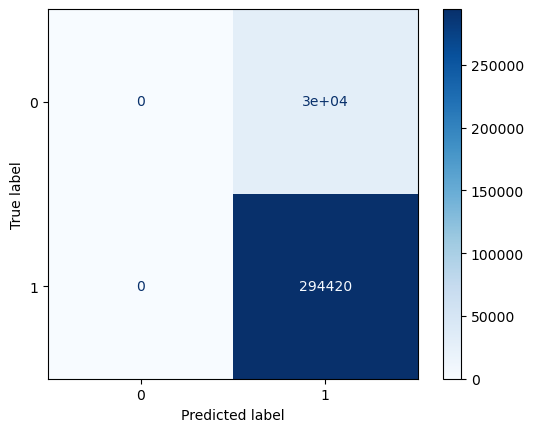

In [30]:
ConfusionMatrixDisplay.from_estimator(pipe, X_val, y_val, cmap='Blues');

In [31]:
# Compute overall accuracy from confusion matrix
overall_accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

In [32]:
# Calculate precision, recall, and F1-score for each class
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
# recall = cm.diagonal() / (cm.sum(axis=1) + 1)
# f1_score = 2 * (precision * recall) / (precision + recall)

In [33]:
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
# print(f"Recall (Sensitivity): {recall}")
# print(f"F1-Score: {f1_score}")

Overall Accuracy: 0.9087
Baseline Accuracy: 0.9080
Precision: 0.9087


# TO-DO >>>

## Data cleaning
~~collapse target into binary~~

## Holdout - best practices 
~~split train val test 80 10 10~~

### Improving performance
## The numerical columns
~~0) add all numeric features back in~~
1) feature engineer multicollinear PROCEEDS variables

## Feature engineering to handle categorical features
exclude categorical vals where there are too many unique values

how to narrow down cat cols:
1) engineer feature to reduce number of unique values by doing top 5, and 'other'
2) ordinal labeling
3) examine feature importance and drop least important, then retrain

### Downsample as needed until it finishes within reasonable time

## Scale back up to more data 
Google colab for scale up

# Optional
cross-validation -- why do we do this
~~no need to boostrap resample, sufficient to binarize~~
~~NN keras~~

## Other kinds of models to try
### Ensembling an ensemble could be interesting
0) RandomForest
1) XGBoost
2) knn
3) SVM
4) Multilayer perceptron NN - fewer hyperparameters